# Quick-start

In [30]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import matplotlib.pyplot as plt

In [36]:
from pydlr import dlr

beta = 100.
d = dlr(lamb=10.*beta)

h = np.array([[1.]])
g_l = d.free_greens_function_tau(h, beta)
tau_l = d.get_tau(beta)

In [37]:
# Transform to DLR coefficients

g_x = d.dlr_from_tau(g_l)

# Evaluate on arbitrary tau grid

tau_i = np.linspace(0, beta, num=1000)
g_i = d.eval_dlr_tau(g_x, tau_i, beta)

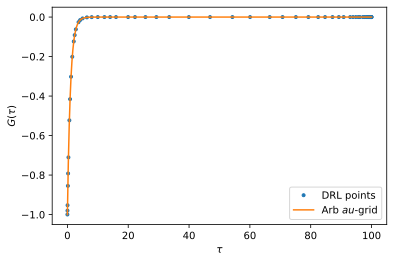

In [38]:
# Plot

plt.plot(tau_l, np.squeeze(g_l), '.', label='DRL points')
plt.plot(tau_i, np.squeeze(g_i), '-', label='Arb $\tau$-grid')
plt.legend(loc='best'); plt.xlabel(r'$\tau$'); plt.ylabel(r'$G(\tau)$')
plt.show()

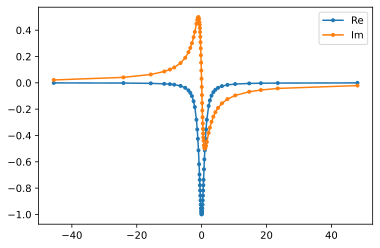

In [40]:
g_w = d.matsubara_from_dlr(g_x, beta)
w = d.get_matsubara_frequencies(beta)

plt.plot(w.imag, np.squeeze(g_w).real, '.-', label='Re')
plt.plot(w.imag, np.squeeze(g_w).imag, '.-', label='Im')
plt.legend(loc='best')
plt.show()

## Dyson equation

The Dyson equation for the single-particle Green's function $G$ is given by

$$
G(i\omega_n) = \left[ i\omega_n - h - \Sigma(i\omega_n) \right]^{-1}
$$

where $\omega_n$ are the Matsubara frequencies, $h$ is the single particle Hamiltonian and $\Sigma$ is the self-energy.

In [41]:
sigma_w = np.zeros_like(g_w)
g_w_ref = d.dyson_matsubara(h, sigma_w, beta)

np.testing.assert_array_almost_equal(g_w_ref, g_w)


An equivalent formulation in imaginary time is given by the integro-differential form

$$
(-\partial_\tau - h - \Sigma \ast ) G(\tau) = 0
$$

with the boundary condition $G(0) - \xi G(\beta) = -1$ and the imaginary time convolution

$$
\Sigma \ast G \equiv \int_{0}^\beta d\bar{\tau} \,
\Sigma(\tau - \bar{\tau}) G(\bar{\tau})
$$

This can further be rewritten using the free Green's function $g$ defined as

$$
(-\partial_\tau - h ) g(\tau) = 0
$$

multiplying the integro-differential form from the left gives the Dyson equation in the integral formulation

$$
(1 + g \ast \Sigma \ast) G = g 
$$

## Volterra equations

## SYK-model example

The SYK model is given by the self-consistent second-order self energy
$$
\Sigma(\tau) = G(-\tau) G^2(\tau)
\. ,
$$
The asymptotic conformal solution is given by
$$

$$